Mount to Google Drive directory

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/pied-paper

/content/drive/My Drive/pied-paper


Change PyTorch and Torchtext version (using legacy features)

In [3]:
!pip install --upgrade torch==1.8.0
!pip install --upgrade torchtext==0.9.0
# !pip show torch
# !pip show torchtext

     |████████████████████████████████| 735.5 MB 13 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0+cu113
    Uninstalling torch-1.11.0+cu113:
      Successfully uninstalled torch-1.11.0+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.12.0+cu113 requires torch==1.11.0, but you have torch 1.8.0 which is incompatible.
torchtext 0.12.0 requires torch==1.11.0, but you have torch 1.8.0 which is incompatible.
torchaudio 0.11.0+cu113 requires torch==1.11.0, but you have torch 1.8.0 which is incompatible.
     |████████████████████████████████| 7.1 MB 5.0 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0


Data has already been preprocessed; it is in 'preprocessed/'

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

from torchtext.legacy.data import Field, TabularDataset, BucketIterator

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

import torch.optim as optim

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Load data as train, valid, test data

In [6]:
# Fields

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.long)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True, fix_length=200)
fields = [('label', label_field), ('title', text_field), ('text', text_field), ('titletext', text_field)]

# TabularDataset

train, valid, test = TabularDataset.splits(path='preprocessed', train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators

train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

# Vocabulary

text_field.build_vocab(train, min_freq=3, vectors="glove.6B.100d")

Build vocabulary and print example words

In [7]:
examples = train.examples
print("Number of tokens: ", len(examples[0].text))
print("\n")
print("Print first 200 tokens: ",examples[0].text[:200])
print("\n")
print("Print last 10 tokens: ",examples[0].text[-10:])

Number of tokens:  21


Print first 200 tokens:  ['killing', 'obama', 'administration', 'rules', ',', 'dismantling', 'obamacare', 'and', 'pushing', 'through', 'tax', 'reform', 'are', 'on', 'the', 'early', 'to', '-', 'do', 'list', '.']


Print last 10 tokens:  ['reform', 'are', 'on', 'the', 'early', 'to', '-', 'do', 'list', '.']


In [8]:
vocab = text_field.vocab

In [9]:

print("Vocabulary size: ", len(vocab))
print("10 most frequent words: ", vocab.freqs.most_common(10))

Vocabulary size:  6243
10 most frequent words:  [('the', 11014), (',', 8985), ('.', 6941), ('to', 4867), ('of', 4833), ('and', 4128), ('a', 4090), ('in', 3603), ('that', 2402), ('is', 1911)]


In [10]:
print("First 10 words: ", vocab.itos[0:10])
print("First 200 words of text data: ", train.examples[0].text[:200])
print("Index of the first word: ", vocab.stoi[train.examples[0].text[0]])

First 10 words:  ['<unk>', '<pad>', 'the', ',', '.', 'to', 'of', 'and', 'a', 'in']
First 200 words of text data:  ['killing', 'obama', 'administration', 'rules', ',', 'dismantling', 'obamacare', 'and', 'pushing', 'through', 'tax', 'reform', 'are', 'on', 'the', 'early', 'to', '-', 'do', 'list', '.']
Index of the first word:  707


Switching test and train iterators

In [82]:
# hold = train_iter 
# train_iter = test_iter
# test_iter = hold

# hold = valid_iter
# valid_iter = test_iter
# test_iter = hold

MLP

Class definition

In [16]:
class TextClass(nn.Module):
  def __init__(self):
    super(TextClass, self).__init__()
    self.embed = nn.Embedding(len(vocab), embedding_dim=100)
    self.embed.weight.data.copy_(vocab.vectors)
    self.fc = nn.Linear(in_features=200*100, out_features=2)
  def forward(self, input, lengths=None):
    embed = self.embed(input)

    if lengths is not None:
      lengths = lengths.view(-1).tolist()
      packed_emb = pack_padded_sequence(embed, lengths)

    embed = embed.reshape(-1, 200*100)

    fc = self.fc(embed)
    out = fc

    return out

Data shape, for debugging purposes

In [17]:
data = next(iter(train_iter))
(x, x_len), y = data.titletext, data.label
print(x.shape)
print(x_len.shape)
print(y.shape)

torch.Size([32, 200])
torch.Size([32])
torch.Size([32])


In [83]:
print(len(train_iter))
print(len(valid_iter))
print(len(test_iter))

178
16
4


Initialize model, optimizer, and loss criterion

In [89]:
device = 'cpu'
model = TextClass().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
print(model)

TextClass(
  (embed): Embedding(6243, 100)
  (fc): Linear(in_features=20000, out_features=2, bias=True)
)


Train model with backpropagation, plot resulting loss curve

In [90]:
# epochs = 20

# model.train()

# losses = []
# for epoch in range(epochs):

#   for batch_num, data in enumerate(train_iter):
#     (x, x_len), y = data.titletext, data.label

#     if batch_num == 0:
#       print(f"Batch num: {batch_num}")
#       print(f"Input data shape: {data}")
#     else:
#       pass

#     optimizer.zero_grad()
#     x = x.to(device)
#     y = y.to(device)

    
#     output = model(x.reshape(-1,200))
#     #if batch_num == 0:
#     #  print(output)
    
#     loss = criterion(output, y)
#     loss.backward()
#     losses.append(loss.item())

#     optimizer.step()
    
#     if batch_num % 100 == 0:
#       print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch, batch_num, loss.item()))
  
#   print('Epoch %d | Loss %6.2f' % (epoch, sum(losses)/len(losses)))
# plt.plot(losses)

Test of embedding layer, for debugging purposes

In [91]:
embedding = nn.Embedding(len(vocab), 100)
input = torch.LongTensor([[1,2,3,4,5],[6,7,8,9,10]])
print(embedding(input).shape)
out = embedding(input)
# out = embedding(input)[:, -1, :]
print(out.shape)

torch.Size([2, 5, 100])
torch.Size([2, 5, 100])


In [92]:
inp = out

In [93]:
# rnn = nn.RNN(input_size=100, hidden_size=128, num_layers=1, batch_first=True)
# h0 = torch.zeros(1, 2, 128)

# out, _ = rnn(inp, h0)
# print(out[:, -1, :].shape)
# print(out.shape)

In [94]:
data = next(iter(test_iter))
(x, x_len), y = data.titletext, data.label
print(model(x).argmax(dim=1))

tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


Train and evaluate model, for accuracy on valid set

In [95]:
def train_model(model, dataloader, device):
  model.train()

  losses = []
  for batch_num, data in enumerate(dataloader):
    (x, x_len), y = data.titletext, data.label

    # if batch_num == 0:
    #   print(f"Batch num: {batch_num}")
    #   print(f"Input data shape: {data}")
    # else:
    #   pass

    optimizer.zero_grad()
    x = x.to(device)
    y = y.to(device)

    
    output = model(x.reshape(-1,200))
    #if batch_num == 0:
    #  print(output)
    
    loss = criterion(output, y)
    loss.backward()
    losses.append(loss.item())

    optimizer.step()
    
    if batch_num % 50 == 0:
      print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch, batch_num, loss.item()))

  print('Epoch %d | Loss %6.2f' % (epoch, sum(losses)/len(losses)))
  # plt.plot(losses)
  return losses

In [96]:
def evaluate_model(model, dataloader, device):
  model.eval()
  with torch.no_grad():
      predictions = []
      num = 1
      for data in test_iter:
          (x, x_len), y_targ = data.titletext, data.label

          x = x.to(device)
          y_targ = y_targ.to(device)

          output = model(x).argmax(dim=1)
          #for y in output:
          #    writer.writerow({fieldnames[0]: image_id,fieldnames[1]: y.item()})
          #    image_id += 1
          
          # if len(test_iter) % num == 5:
          #   print(output)
          #   print(y_targ)
          #   print(output.shape)
          #   print(torch.eq(output, y_targ))
          #   #print(sum(torch.eq(output, y_targ)).item())

          num += 1
          eq = torch.eq(output, y_targ)
          for element in eq:
            predictions.append(element)
      
      accuracy = sum(predictions) / len(predictions)
      print(f"Length of predictions: {len(predictions)}")
      # print(f"Accuracy : {accuracy}")
      return accuracy
      

In [97]:
list1 = [1,2,3,4]
list2 = [4,5,6,7]
list3 = []
list3.extend(list1)
list3.extend(list2)
print(list3)

[1, 2, 3, 4, 4, 5, 6, 7]


	Epoch 0 | Batch 0 | Loss   0.70
	Epoch 0 | Batch 50 | Loss   0.93
	Epoch 0 | Batch 100 | Loss   1.23
	Epoch 0 | Batch 150 | Loss   0.20
Epoch 0 | Loss   0.65
Length of predictions: 127
Valid accuracy: 0.7795275449752808
	Epoch 1 | Batch 0 | Loss   0.45
	Epoch 1 | Batch 50 | Loss   0.17
	Epoch 1 | Batch 100 | Loss   0.23
	Epoch 1 | Batch 150 | Loss   0.04
Epoch 1 | Loss   0.13
Length of predictions: 127
Valid accuracy: 0.748031497001648
	Epoch 2 | Batch 0 | Loss   0.67
	Epoch 2 | Batch 50 | Loss   0.07
	Epoch 2 | Batch 100 | Loss   0.04
	Epoch 2 | Batch 150 | Loss   0.05
Epoch 2 | Loss   0.16
Length of predictions: 127
Valid accuracy: 0.7795275449752808
	Epoch 3 | Batch 0 | Loss   0.62
	Epoch 3 | Batch 50 | Loss   0.01
	Epoch 3 | Batch 100 | Loss   0.05
	Epoch 3 | Batch 150 | Loss   0.90
Epoch 3 | Loss   0.34
Length of predictions: 127
Valid accuracy: 0.8661417365074158
	Epoch 4 | Batch 0 | Loss   0.41
	Epoch 4 | Batch 50 | Loss   0.00
	Epoch 4 | Batch 100 | Loss   0.00
	Epoch 4 | Batc

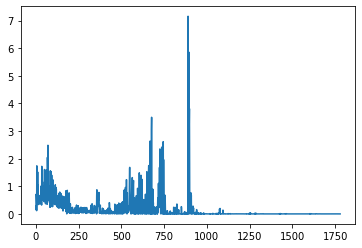

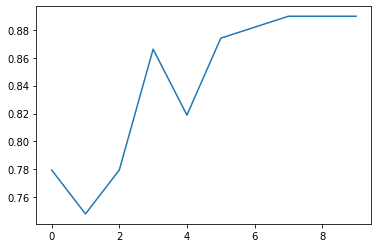

In [98]:
epochs = 10
tot_losses = []
accuracies = []

for epoch in range(epochs):
  losses = train_model(model, train_iter, device)
  tot_losses.extend(losses)
  accuracy = evaluate_model(model, valid_iter, device)
  accuracies.append(accuracy)
  print(f"Valid accuracy: {accuracy}")

plt.figure()
plt.plot(tot_losses)
plt.figure()
plt.plot(accuracies)

Model accuracy on test set

In [99]:
test_acc = evaluate_model(model, test_iter, device)
print(f"Test accuracy: {test_acc}")

Length of predictions: 127
Test accuracy: 0.8897637724876404


In [ ]:
# import itertools

# model.eval()
# with torch.no_grad():
#         predictions = []
#         num = 1
#         for data in test_iter:
#             (x, x_len), y_targ = data.titletext, data.label

#             x = x.to(device)
#             y_targ = y_targ.to(device)

#             output = model(x).argmax(dim=1)
#             #for y in output:
#             #    writer.writerow({fieldnames[0]: image_id,fieldnames[1]: y.item()})
#             #    image_id += 1
            
#             if len(test_iter) % num == 5:
#               print(output)
#               print(y_targ)
#               print(output.shape)
#               print(torch.eq(output, y_targ))
#               #print(sum(torch.eq(output, y_targ)).item())

#             num += 1
#             eq = torch.eq(output, y_targ)
#             for element in eq:
#               predictions.append(element)
        
#         accuracy = sum(predictions) / len(predictions)
#         print(f"Length of predictions: {len(predictions)}")
#         print(f"Accuracy : {accuracy}")
        

tensor([1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 1, 1, 0, 1, 0, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1])
torch.Size([32])
tensor([False,  True,  True,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True, False,  True,  True,  True, False,  True,
        False,  True,  True,  True,  True, False, False,  True, False,  True,
         True,  True])
Length of predictions: 5670
Accuracy : 0.7643738985061646


In [60]:
print(len(train_iter))
print(len(valid_iter))
print(len(test_iter))

178
4
16


CNN

In [100]:
class TextClassCNN(nn.Module):
  def __init__(self):
    super(TextClassCNN, self).__init__()
    self.embed = nn.Embedding(len(vocab), embedding_dim=100)
    self.embed.weight.data.copy_(vocab.vectors)
    self.seq = nn.Sequential(
        nn.Conv2d(in_channels=100, out_channels=64, kernel_size=(3,1), padding=(1,0)),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,1), padding=(1,0)),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3,1), padding=(1,0)),
        nn.ReLU()
    )
    self.fc = nn.Linear(in_features=16*200, out_features=2)
  def forward(self, input, lengths=None):
    embed = self.embed(input)

    if lengths is not None:
      lengths = lengths.view(-1).tolist()
      packed_emb = pack_padded_sequence(embed, lengths)

    embed = embed.reshape(-1, 100, 200, 1)

    seq = self.seq(embed)
    res = seq.reshape(-1, 16*200)

    fc = self.fc(res)
    out = fc

    return out

In [101]:
data = next(iter(train_iter))
(x, x_len), y = data.titletext, data.label
print(x.shape)
print(x_len.shape)
print(y.shape)

torch.Size([32, 200])
torch.Size([32])
torch.Size([32])


In [102]:
device = 'cpu'
cnn_model = TextClassCNN().to(device)
optimizer = torch.optim.Adam(cnn_model.parameters())
criterion = nn.CrossEntropyLoss()
print(cnn_model)

TextClassCNN(
  (embed): Embedding(6243, 100)
  (seq): Sequential(
    (0): Conv2d(100, 64, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
    (3): ReLU()
    (4): Conv2d(32, 16, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0))
    (5): ReLU()
  )
  (fc): Linear(in_features=3200, out_features=2, bias=True)
)


	Epoch 0 | Batch 0 | Loss   0.69
	Epoch 0 | Batch 50 | Loss   0.73
	Epoch 0 | Batch 100 | Loss   0.74
	Epoch 0 | Batch 150 | Loss   0.55
Epoch 0 | Loss   0.69
Length of predictions: 127
	Epoch 1 | Batch 0 | Loss   0.70
	Epoch 1 | Batch 50 | Loss   0.40
	Epoch 1 | Batch 100 | Loss   0.50
	Epoch 1 | Batch 150 | Loss   0.17
Epoch 1 | Loss   0.41
Length of predictions: 127
	Epoch 2 | Batch 0 | Loss   0.39
	Epoch 2 | Batch 50 | Loss   0.20
	Epoch 2 | Batch 100 | Loss   0.19
	Epoch 2 | Batch 150 | Loss   0.05
Epoch 2 | Loss   0.19
Length of predictions: 127
	Epoch 3 | Batch 0 | Loss   0.46
	Epoch 3 | Batch 50 | Loss   0.10
	Epoch 3 | Batch 100 | Loss   0.05
	Epoch 3 | Batch 150 | Loss   0.02
Epoch 3 | Loss   0.11
Length of predictions: 127
	Epoch 4 | Batch 0 | Loss   0.17
	Epoch 4 | Batch 50 | Loss   0.04
	Epoch 4 | Batch 100 | Loss   0.01
	Epoch 4 | Batch 150 | Loss   0.01
Epoch 4 | Loss   0.04
Length of predictions: 127
	Epoch 5 | Batch 0 | Loss   0.07
	Epoch 5 | Batch 50 | Loss   0.09
	Ep

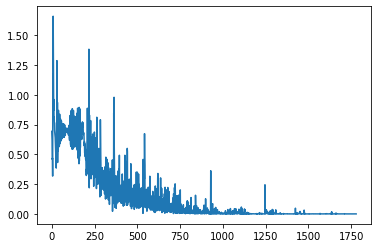

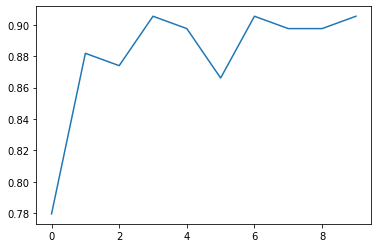

In [103]:
epochs = 10
tot_losses = []
accuracies = []

for epoch in range(epochs):
  losses = train_model(cnn_model, train_iter, device)
  tot_losses.extend(losses)
  accuracy = evaluate_model(cnn_model, valid_iter, device)
  accuracies.append(accuracy)

plt.figure()
plt.plot(tot_losses)
plt.figure()
plt.plot(accuracies)

Model accuracy on test set

In [104]:
test_acc = evaluate_model(cnn_model, test_iter, device)
print(f"Test accuracy: {test_acc}")

Length of predictions: 127
Test accuracy: 0.9055117964744568


In [105]:
evaluate_model(cnn_model, train_iter, device)

Length of predictions: 127


tensor(0.9055)

Batch num: 0
Input data shape: 
[torchtext.legacy.data.batch.Batch of size 32]
	[.label]:[torch.LongTensor of size 32]
	[.title]:('[torch.LongTensor of size 32x200]', '[torch.LongTensor of size 32]')
	[.text]:('[torch.LongTensor of size 32x200]', '[torch.LongTensor of size 32]')
	[.titletext]:('[torch.LongTensor of size 32x200]', '[torch.LongTensor of size 32]')
	Epoch 0 | Batch 0 | Loss   0.69
Epoch 0 | Loss   0.70
Batch num: 0
Input data shape: 
[torchtext.legacy.data.batch.Batch of size 32]
	[.label]:[torch.LongTensor of size 32]
	[.title]:('[torch.LongTensor of size 32x200]', '[torch.LongTensor of size 32]')
	[.text]:('[torch.LongTensor of size 32x200]', '[torch.LongTensor of size 32]')
	[.titletext]:('[torch.LongTensor of size 32x200]', '[torch.LongTensor of size 32]')
	Epoch 1 | Batch 0 | Loss   0.69
Epoch 1 | Loss   0.70
Batch num: 0
Input data shape: 
[torchtext.legacy.data.batch.Batch of size 32]
	[.label]:[torch.LongTensor of size 32]
	[.title]:('[torch.LongTensor of size 32x

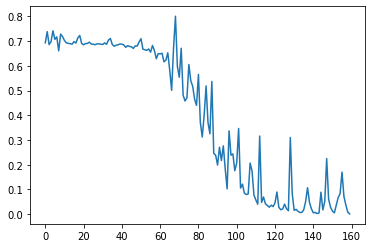

In [ ]:
# epochs = 10

# cnn_model.train()

# losses = []
# for epoch in range(epochs):

#   for batch_num, data in enumerate(train_iter):
#     (x, x_len), y = data.titletext, data.label

#     if batch_num == 0:
#       print(f"Batch num: {batch_num}")
#       print(f"Input data shape: {data}")
#     else:
#       pass

#     optimizer.zero_grad()
#     x = x.to(device)
#     y = y.to(device)

    
#     output = cnn_model(x)
#     #if batch_num == 0:
#     #  print(output)
    
#     loss = criterion(output, y)
#     loss.backward()
#     losses.append(loss.item())

#     optimizer.step()
    
#     if batch_num % 100 == 0:
#       print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch, batch_num, loss.item()))
  
#   print('Epoch %d | Loss %6.2f' % (epoch, sum(losses)/len(losses)))
# plt.plot(losses)

In [106]:
# import itertools

# cnn_model.eval()
# with torch.no_grad():
#         predictions = []
#         num = 1
#         for data in test_iter:
#             (x, x_len), y_targ = data.titletext, data.label

#             x = x.to(device)
#             y_targ = y_targ.to(device)

#             output = cnn_model(x).argmax(dim=1)
#             #for y in output:
#             #    writer.writerow({fieldnames[0]: image_id,fieldnames[1]: y.item()})
#             #    image_id += 1
            
#             if len(test_iter) % num == 5:
#               print(output)
#               print(y_targ)
#               print(output.shape)
#               print(torch.eq(output, y_targ))
#               #print(sum(torch.eq(output, y_targ)).item())

#             num += 1
#             eq = torch.eq(output, y_targ)
#             for element in eq:
#               predictions.append(element)
        
#         accuracy = sum(predictions) / len(predictions)
#         print(f"Length of predictions: {len(predictions)}")
#         print(f"Accuracy : {accuracy}")
        

RNN

In [107]:
input_size = 100
sequence_length = 200
hidden_size = 128
num_layers = 1
num_classes = 2

In [108]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(RNN, self).__init__()
    self.input_size = input_size
    self.sequence_length = 200
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.num_classes = num_classes
    self.samp_num = 0

    self.embed = nn.Embedding(len(vocab), embedding_dim=100)
    self.embed.weight.data.copy_(vocab.vectors)

    self.rnn = nn.RNN(self.input_size, self.hidden_size, self.num_layers, batch_first = True)  
    self.linear = nn.Linear(self.hidden_size, self.num_classes)
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    # c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

    embed = self.embed(x)
    embed = embed.reshape(-1, 200, 100)

    out, _ = self.rnn(embed, h0)
    if self.samp_num % 1000 == 0:
      print(f"RNN output: {out.shape}")
    out = out[:, -1, :]
    if self.samp_num % 1000 == 0:
      print(f"Reshaped RNN output: {out.shape}")

    self.samp_num += 1

    out = self.linear(out)
    return out

In [109]:
#  test = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
#  x, y = next(train(iter))
#  x = x[1][0]
#  y = x
#
#  h0 = torch.zeros(num_layers, x.size(0), hidden_size)

In [110]:
device = 'cpu'
rnn_model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5)

In [111]:
print(rnn_model)

RNN(
  (embed): Embedding(6243, 100)
  (rnn): RNN(100, 128, batch_first=True)
  (linear): Linear(in_features=128, out_features=2, bias=True)
)


RNN output: torch.Size([32, 200, 128])
Reshaped RNN output: torch.Size([32, 128])
	Epoch 0 | Batch 0 | Loss   0.69
	Epoch 0 | Batch 50 | Loss   0.68
	Epoch 0 | Batch 100 | Loss   0.90
	Epoch 0 | Batch 150 | Loss   0.57
Epoch 0 | Loss   0.69
Length of predictions: 127
	Epoch 1 | Batch 0 | Loss   0.73
	Epoch 1 | Batch 50 | Loss   0.70
	Epoch 1 | Batch 100 | Loss   0.89
	Epoch 1 | Batch 150 | Loss   0.52
Epoch 1 | Loss   0.66
Length of predictions: 127
	Epoch 2 | Batch 0 | Loss   0.54
	Epoch 2 | Batch 50 | Loss   0.64
	Epoch 2 | Batch 100 | Loss   0.73
	Epoch 2 | Batch 150 | Loss   0.44
Epoch 2 | Loss   0.61
Length of predictions: 127
	Epoch 3 | Batch 0 | Loss   1.07
	Epoch 3 | Batch 50 | Loss   0.68
	Epoch 3 | Batch 100 | Loss   0.71
	Epoch 3 | Batch 150 | Loss   0.35
Epoch 3 | Loss   0.58
Length of predictions: 127
	Epoch 4 | Batch 0 | Loss   0.71
	Epoch 4 | Batch 50 | Loss   0.62
	Epoch 4 | Batch 100 | Loss   0.42
	Epoch 4 | Batch 150 | Loss   0.18
Epoch 4 | Loss   0.48
Length of predi

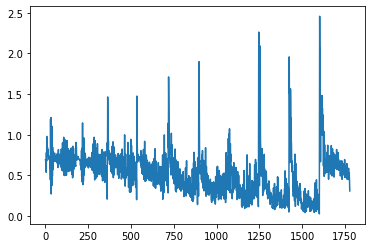

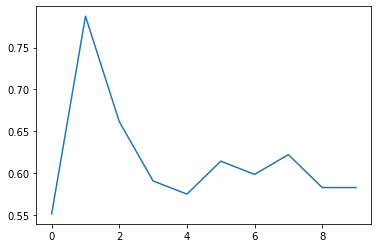

In [112]:
epochs = 10
tot_losses = []
accuracies = []

for epoch in range(epochs):
  losses = train_model(rnn_model, train_iter, device)
  tot_losses.extend(losses)
  accuracy = evaluate_model(rnn_model, valid_iter, device)
  accuracies.append(accuracy)

plt.figure()
plt.plot(tot_losses)
plt.figure()
plt.plot(accuracies)

Model accuracy on test set

In [113]:
test_acc = evaluate_model(rnn_model, test_iter, device)
print(f"Test accuracy: {test_acc}")

Length of predictions: 127
Test accuracy: 0.5826771855354309


In [65]:
# batch_num, input_data = next(enumerate(train_iter))
# x, y_targ = input_data
# print(batch_num)
# print(len(x))
# print(x[0])
# print(len(x[1]))
# print(len(x[2]))
# print(len(x[3]))
# print(x[1][0].shape)
# print(x[1][1])
# print(x[2][0].shape)
# print(x[2][1])
# print(x[3][0].shape)
# print(x[3][1])
# print(x[3][0].size(0))

0
4
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1])
2
2
2
torch.Size([32, 200])
tensor([ 9, 10,  5, 11,  9,  8,  8,  9,  8,  9,  8,  9,  7, 10, 15, 15, 14,  7,
        11,  7,  5,  4, 14, 11, 13, 11,  7,  3, 12, 20, 20,  8])
torch.Size([32, 200])
tensor([12, 12, 12, 12, 12, 12, 12, 12, 11, 11, 11, 10, 10, 10, 10,  9,  9,  9,
         9,  8,  8,  8,  8,  8,  8,  8,  8,  7,  4,  2,  2,  1])
torch.Size([32, 200])
tensor([21, 22, 17, 23, 21, 20, 20, 21, 19, 20, 19, 19, 17, 20, 25, 24, 23, 16,
        20, 15, 13, 12, 22, 19, 21, 19, 15, 10, 16, 22, 22,  9])
32


In [66]:
# def rnn_train(model, dataloader, device):
  
#   model.train()

#   losses=[]
#   for batch_num, input_data in enumerate(dataloader):
#     if batch_num == 0 or batch_num == round(len(input_data) / batch_size)-1:
#       print(f"Batch num: {batch_num}")
#       i1, i2 = input_data
#       print(f"Input data shape: {i1[1][0].shape}")
#     else:
#       pass
    
#     optimizer.zero_grad()
#     a, b = input_data
#     x = a[3][0]
#     y = a[0]
#     x = x.to(device)
#     y = y.to(device)

#     output = model(x)
#     loss = criterion(output, y)
#     loss.backward()
#     losses.append(loss.item())

#     optimizer.step()

#     curr_lr = optimizer.param_groups[0]['lr']
#     scheduler.step(loss / len(train_iter))

#     if batch_num % 100 == 0:
#       print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch, batch_num, loss.item()))
#   print('Epoch %d | Loss %6.2f' % (epoch, sum(losses)/len(losses)))
#   plt.plot(losses)


In [67]:
# def rnn_evaluate(model, dataloader, device):

#   model.eval()

#   with torch.no_grad():
#     predictions = []
#     for a, b in dataloader:
#       x = a[3][0].to(device)
#       y_targ = a[0].to(device)

#       output = model(x).argmax(dim=1)
#       predictions.append(torch.eq(output, y_targ))

#       tot_sum = 0
#       tot_len = 0

#       for tensor in predictions:
#         tot_sum += sum(tensor)
#         tot_len += len(tensor)
#       accuracy = tot_sum / tot_len

#       print(f"Total number of predictions: {tot_len}")
#       print(f"Total accuracy: {accuracy}")

#       return accuracy

In [ ]:
# epochs = 20
# batch_size = 32

# for epoch in range(epochs):
#   accuracies = []
#   rnn_train(rnn_model, train_iter, device)
#   accuracy = rnn_evaluate(rnn_model, train_iter, device)
#   accuracies.append(accuracy)
#   print(f"Train accuracy: {accuracy}")

Batch num: 0
Input data shape: torch.Size([32, 200])
RNN output: torch.Size([32, 200, 128])
Reshaped RNN output: torch.Size([32, 128])
	Epoch 0 | Batch 0 | Loss   0.69
	Epoch 0 | Batch 100 | Loss   0.83
Epoch 0 | Loss   0.72
Total number of predictions: 32
Total accuracy: 0.53125
Train accuracy: 0.53125
Batch num: 0
Input data shape: torch.Size([32, 200])
	Epoch 1 | Batch 0 | Loss   0.70
	Epoch 1 | Batch 100 | Loss   0.83
Epoch 1 | Loss   0.71
Total number of predictions: 32
Total accuracy: 0.53125
Train accuracy: 0.53125
Batch num: 0
Input data shape: torch.Size([32, 200])
	Epoch 2 | Batch 0 | Loss   0.70
	Epoch 2 | Batch 100 | Loss   0.83
Epoch 2 | Loss   0.71
Total number of predictions: 32
Total accuracy: 0.53125
Train accuracy: 0.53125
Batch num: 0
Input data shape: torch.Size([32, 200])
	Epoch 3 | Batch 0 | Loss   0.70
	Epoch 3 | Batch 100 | Loss   0.83
Epoch 3 | Loss   0.71
Total number of predictions: 32
Total accuracy: 0.53125
Train accuracy: 0.53125
Batch num: 0
Input data sh

In [20]:
# epochs = 20
# batch_size = 32

# rnn_model.train()

# losses=[]
# for epoch in range(epochs):
#   for batch_num, input_data in enumerate(train_iter):
#     if batch_num == 0 or batch_num == round(len(input_data) / batch_size)-1:
#       print(f"Batch num: {batch_num}")
#       i1, i2 = input_data
#       print(f"Input data shape: {i1[1][0].shape}")
#     else:
#       pass
    
#     optimizer.zero_grad()
#     a, b = input_data
#     x = a[3][0]
#     y = a[0]
#     x = x.to(device)
#     y = y.to(device)

#     output = rnn_model(x)
#     loss = criterion(output, y)
#     loss.backward()
#     losses.append(loss.item())

#     optimizer.step()

#     curr_lr = optimizer.param_groups[0]['lr']
#     scheduler.step(loss / len(train_iter))

#     if batch_num % 100 == 0:
#       print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch, batch_num, loss.item()))
#   print('Epoch %d | Loss %6.2f' % (epoch, sum(losses)/len(losses)))
# plt.plot(losses)


Batch num: 0
Input data shape: torch.Size([32, 200])
RNN output: torch.Size([32, 200, 128])
Reshaped RNN output: torch.Size([32, 128])
	Epoch 0 | Batch 0 | Loss   0.70
RNN output: torch.Size([32, 200, 128])
Reshaped RNN output: torch.Size([32, 128])
RNN output: torch.Size([32, 200, 128])
Reshaped RNN output: torch.Size([32, 128])
RNN output: torch.Size([32, 200, 128])
Reshaped RNN output: torch.Size([32, 128])
RNN output: torch.Size([32, 200, 128])
Reshaped RNN output: torch.Size([32, 128])
RNN output: torch.Size([32, 200, 128])
Reshaped RNN output: torch.Size([32, 128])
RNN output: torch.Size([32, 200, 128])
Reshaped RNN output: torch.Size([32, 128])
RNN output: torch.Size([32, 200, 128])
Reshaped RNN output: torch.Size([32, 128])
RNN output: torch.Size([32, 200, 128])
Reshaped RNN output: torch.Size([32, 128])
RNN output: torch.Size([32, 200, 128])
Reshaped RNN output: torch.Size([32, 128])
RNN output: torch.Size([32, 200, 128])
Reshaped RNN output: torch.Size([32, 128])
RNN output: 

KeyboardInterrupt: ignored

In [34]:
# import csv
# rnn_model.eval()

# with open('cnn_submission.csv', 'w') as f:
#     fieldnames = ['ImageId', 'Label']
#     writer = csv.DictWriter(f, fieldnames=fieldnames, lineterminator = '\n')
#     writer.writeheader()
#     image_id = 1

#     with torch.no_grad():
#         predictions = []
#         num = 1
#         for a, b in test_iter:
#             x = a[1][0]
#             y_targ = a[0]

#             output = rnn_model(x).argmax(dim=1)
#             for y in output:
#                 writer.writerow({fieldnames[0]: image_id,fieldnames[1]: y.item()})
#                 image_id += 1
            
#             if len(test_iter) % num == 5:
#               print(output)
#               print(y_targ)

#             num += 1
#             predictions.append(torch.eq(output, y_targ))
        
#         print(predictions[0])
#         print(predictions[0].shape)
#         print(sum(predictions[:2]))
#         print(len(predictions))
#         tot_sum = 0
#         tot_len = 0
#         for tensor in predictions:
#           tot_sum += sum(tensor)
#           tot_len += len(tensor)
#         accuracy = tot_sum / tot_len
#         print(f"Length of predictions: {tot_len}")
#         print(f"Accuracy : {accuracy}")
        

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1])
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True])
torch.Size([32])
tensor([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1])
178
Length of predictions: 5670
Accuracy : 0.49664902687072754
